In [4]:
# Enalce a base de datos: 
# https://www.kaggle.com/datasets/eliasturk/world-happiness-based-on-cpi-20152020

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import( 
                            mean_absolute_error as mae, 
                            mean_absolute_percentage_error as mape
                        )

import statsmodels.api as sm
from scipy import stats
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

In [6]:
hapcor = pd.read_csv("WorldHappiness_Corruption_2015_2020.csv")

In [8]:
df = hapcor.copy()

In [9]:
df.sample(3)

,Country,happiness_score,gdp_per_capita,family,health,freedom,generosity,government_trust,dystopia_residual,continent,Year,social_support,cpi_score
261,Benin,3.3400,0.28665,0.35386,0.319100,0.484500,0.182600,0.080100,1.633280,Africa,2016,0.000000,36
780,Sierra Leone,3.9264,0.24056,0.00000,0.203954,0.382028,0.257647,0.047941,2.046272,Africa,2020,0.747985,33
214,Bosnia and Herzegovina,4.9490,0.83223,0.91916,0.790810,0.092450,0.248080,0.002270,2.063670,Europe,2016,0.000000,39


## 1. Regresión univariable (Happiness Score vs CPI score)

In [ ]:
# El supuesto de la regresión lineal es independiencia, hocedaasticidad y normalidad

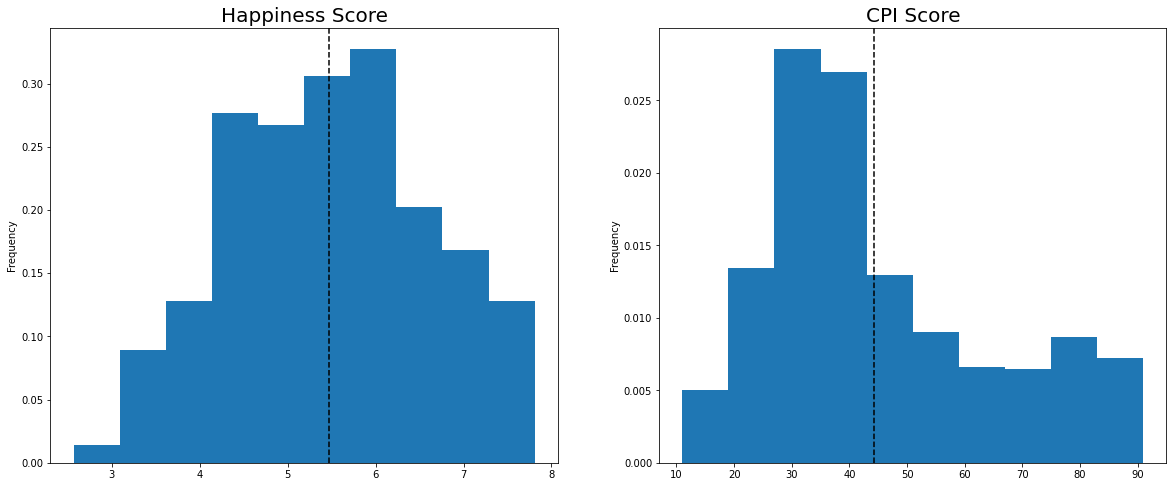

In [10]:
# Las variables son normales?
fig, ax = plt.subplots(1,2, figsize=(20, 8))
df.happiness_score.plot(kind="hist", ax=ax[0], title="Happiness Score", density=True)
ax[0].title.set_size(20)
ax[0].axvline(df.happiness_score.mean(), linestyle="dashed", c="k")
df.cpi_score.plot(kind="hist", ax=ax[1], title="CPI Score", density=True)
ax[1].axvline(df.cpi_score.mean(), linestyle="dashed", c="k")
ax[1].title.set_size(20)

In [11]:
# Debido a que es mas facil para el modelo de regresscion de Sklearn encontrar valores de 
# beta_1 > 1 se normalizara la variable independiente
X = normalize(df[["cpi_score"]].to_numpy(), axis=0)
y = df.happiness_score.to_numpy()

#### 1.1 Entrenar y predecir

In [12]:
(X_train, X_test, y_train, y_test) = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=True,
    random_state=1
)
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

#### 1.2 Obtener coeficientes

In [13]:
print(f"Coeficientes encontrados:\n\tbeta_1: {model.coef_}\n\tbeta_0: {model.intercept_}")

Coeficientes encontrados:
	beta_1: [54.23040134]
	beta_0: 3.70053695461512


#### 1.3 Calcular precisión

In [14]:
model.score(X_train, y_train)

0.46501665787353985

In [15]:
print(
    f"""Metrícas de Precisión:
    \tR^2: {model.score(X_test, y_test)}
    \tmae: {mae(y_test, y_pred)}
    \tmape: {mape(y_test, y_pred)}"""
)

Metrícas de Precisión:
    	R^2: 0.5403265145740164
    	mae: 0.6130206510525839
    	mape: 0.12379785843894273


#### 1.4 Hipotesis prueba $\beta_1$
$H_0: \quad \beta_1 = 0$

$H_1: \quad \beta_1 \neq 0$

In [16]:
error=(y_test-y_pred)
ds_error=error.std()
ds_X=X_test.std()
error_st=ds_error/np.sqrt(y.shape)
# Test 'T de student'
t1=model.coef_/(error_st/ds_X)
print(t1)
# Segun la tabla de la prueba T student, 
# para una prueba de dos colas
# cuando n=infinito:
# t = 3.316

[30.00983487]


In [17]:
# ya que 30.00983487 > 3.316, se rechaza la hipotesis nula para beta_1

#### 1.5 Hipotesis prueba $\beta_0$
$H_0: \quad \beta_0 = 0$

$H_1: \quad \beta_0 \neq 0$

In [18]:
media_X=X_test.mean()
media_XC=pow(media_X,2)
var_X=X_test.var()
to=model.intercept_/(error_st*np.sqrt(1+(media_XC/var_X)))
print(to)
# >> ~57.92 # se rechaza la hipotesis nula para beta_0

[57.92349981]


#### 1.6 Gráfico de modelo ajustado

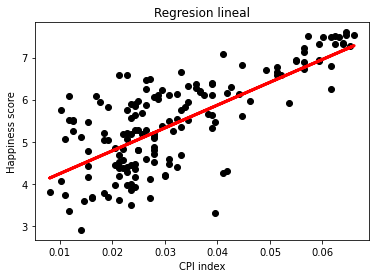

In [236]:
plt.scatter(X_test, y_test, color='k')
plt.plot(X_test,y_pred, color='r',linewidth=3)
plt.title('Regresion lineal')
plt.xlabel('CPI index')
plt.ylabel('Happiness score')
plt.show()

#### 1.7 Obtención de estadísticos

In [27]:
X_2 = sm.add_constant(X_train, prepend=True)
rls = sm.OLS(y_train, X_2)
modelo_2 = rls.fit()
print(modelo_2.summary())
y_pred_2 = modelo_2.predict()
error_2 = modelo_2.resid

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     548.5
Date:                Wed, 19 Oct 2022   Prob (F-statistic):           9.09e-88
Time:                        15:31:19   Log-Likelihood:                -774.01
No. Observations:                 633   AIC:                             1552.
Df Residuals:                     631   BIC:                             1561.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7005      0.082     44.917      0.0

De la tabla anterior:

Se obtuvo un R-squared de 0.465 lo que significa que nuestro modelo no representa la tendencia de los datos y por tanto no podrá predecir correctamente en la mayoría de los casos.

La probabilidad de F-statistics tiene un valor muy cercano a 0 lo que significa que se puede rechazar la hipótesis de que el modelo es bueno.

de la probabilidad de la Prueba de t student se puede ver que la se rechazan las 2 hipótesis nulas de los coeficientes $\beta_0$ y $\beta_1$. Por lo tanto, se sabe que la pendiente no es igual a 0 y la ordenada al origen no es cero.

De la probabilidad de la prueba Omnibus se sabe que valores cercanos a cero, indican que la distribución de los residuos no es normal.

Con la prueba de Drubin-Watson, se puede deducir que `los errores` presentan muy poca heterocedasticidad.

De los valores de curtosis y sesgo, se puede saber que la cola de los errores tiende a valores hacia la izquierda y la distribución tiene una forma apuntada. 

#### 1.8 Gráfico de residuos

C:\Users\alber\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


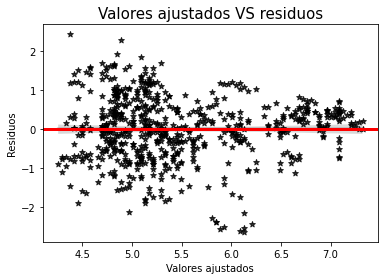

In [112]:
sns.regplot(y_pred_2, error_2, marker='*', color='k')
plt.axhline(0, color='r', linewidth=3)
plt.xlabel('Valores ajustados', size=10)
plt.ylabel('Residuos', size=10)
plt.title('Valores ajustados VS residuos', size=15);


#### 1.9 Gráfico de distribucion de residuos y residuos vs valor ajustado

C:\Users\alber\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribución de residuos')

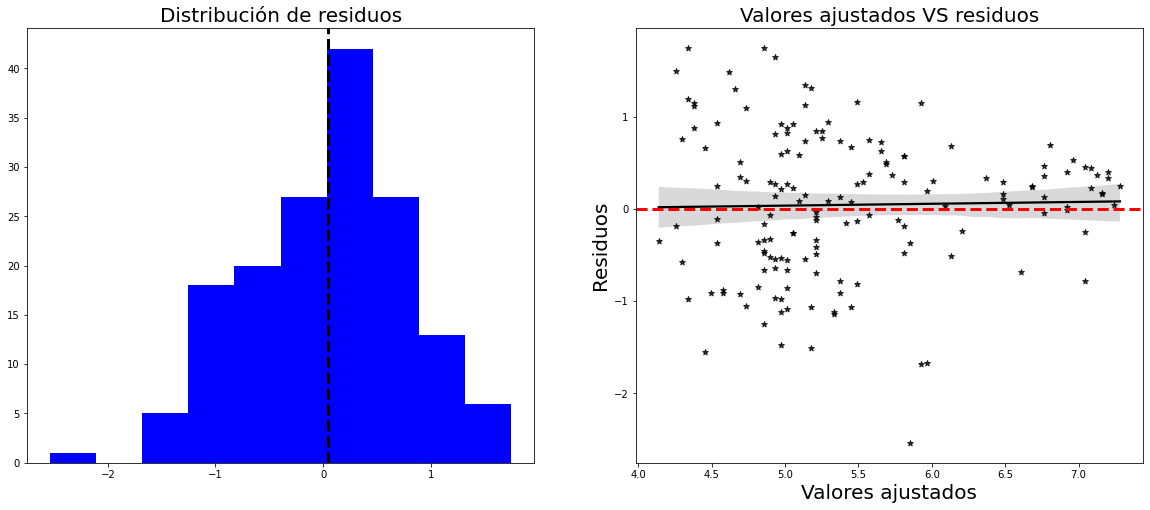

In [113]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), sharey=False)
sns.regplot(y_pred, error, marker='*', color='k', ax=ax[1])
ax[1].axhline(0, color='r', linestyle="dashed", linewidth=3)
ax[1].set_xlabel('Valores ajustados', size=20)
ax[1].set_ylabel('Residuos', size=20)
ax[1].set_title('Valores ajustados VS residuos', size=20)

ax[0].hist(error, color='blue')
ax[0].axvline(error.mean(), linestyle="dashed", c="k", linewidth=3)
ax[0].set_title('Distribución de residuos', size=20)

#### 1.10 Gráfico de distribución de residuos y Q-Q Plot

C:\Users\alber\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


Text(0.5, 1.0, 'Distribución de residuos')

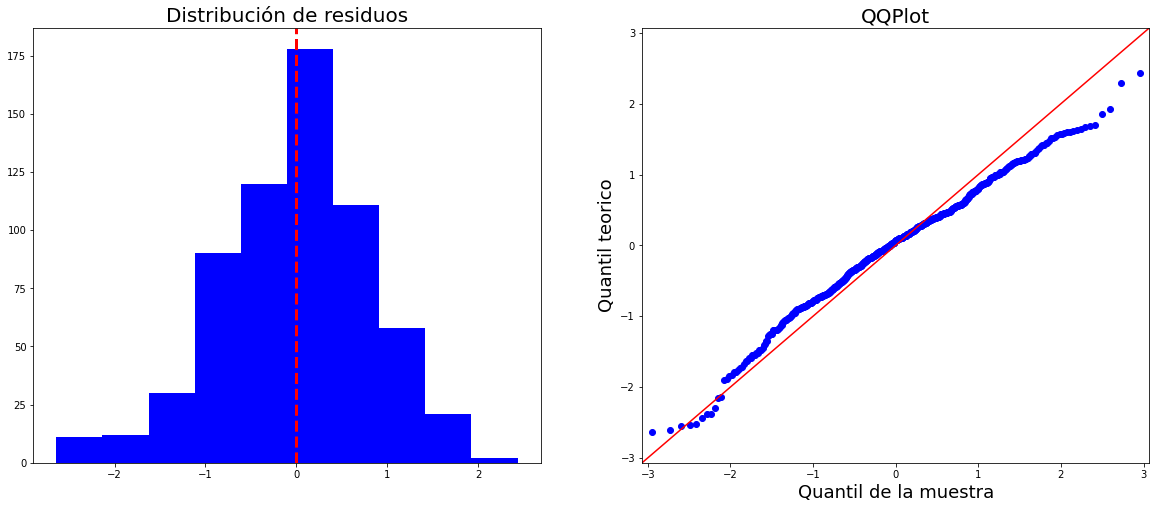

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), sharey=False)

sm.qqplot(modelo_2.resid, line='45', ax=ax[1])
ax[1].set_title('QQPlot', size=20)
ax[1].set_xlabel('Quantil de la muestra', size=18)
ax[1].set_ylabel('Quantil teorico', size=18)

ax[0].hist(error_2, color='blue')
ax[0].axvline(error_2.mean(), linestyle="dashed", c="red", linewidth=3)
ax[0].set_title('Distribución de residuos', size=20)

#### 1.11 Pruebas de Normalidad y Homocedasticidad

In [185]:
#Ho: Normalidad (p>0.05)
#H1: No normalidad (p<0.05)
names=[' Statistic', 'p-value']
test=stats.shapiro(modelo_2.resid)
lzip(names,test)

[(' Statistic', 0.9895108342170715), ('p-value', 0.00017160273273475468)]

In [186]:
#Breusch-Pagan
#H0: Homocedasticidad (p>0.05)
#H1: No homocedasticidad (p<0.05)
names=['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(modelo_2.resid, X_2)
lzip(names, test)

[('Lagrange multiplier statistic', 12.946976824739401),
 ('p-value', 0.00032043854677640343),
 ('f-value', 13.17555446238249),
 ('f p-value', 0.00030661040116623946)]

## 2. Regresion multivariable

In [115]:
df.columns

Index(['Country', 'happiness_score', 'gdp_per_capita', 'family', 'health',
       'freedom', 'generosity', 'government_trust', 'dystopia_residual',
       'continent', 'Year', 'social_support', 'cpi_score'],
      dtype='object')

In [108]:
X_multiple = (    
    df
    .drop(columns=["Country", "happiness_score"])
    .pipe(pd.get_dummies, drop_first=True)
    .apply(lambda k: k/k.max())
)

y_multiple=df[["cpi_score"]]

#### 2.1 Obtención de estadísticos

In [109]:
# generate OLS model
modelo_multiple = sm.OLS(y_multiple, sm.add_constant(X_multiple))
modelo_fit = modelo_multiple.fit()
print(modelo_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              cpi_score   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.723e+27
Date:                Wed, 19 Oct 2022   Prob (F-statistic):               0.00
Time:                        21:24:18   Log-Likelihood:                 19796.
No. Observations:                 792   AIC:                        -3.956e+04
Df Residuals:                     776   BIC:                        -3.948e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    4

C:\Users\alber\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


De la tabla anterior, se puede ver que tanto `R-squared`, como `Adj. R-squared` tienen un valor de 1, también se puede observar que la probabilidad de la prueba `F-statistics` tiene un valor de 0, lo que indica que toda la variabilidad esta explicada con el modelo encontrado.

De las probabilidades de la Prueba de omnibus se rechaza la hipótesis de que la distribución de los residuos sigue una distribución normal.

De la prueba de Durbin Watson se obtiene un valor igual a 0, lo que indica heterocedasticidad y una alta correlación entre las variables, esto se puede sustentar con el valor de AIC y BIC, los cuales tienen un valor absoluto aproximadamente 2 veces mayor al obtenido con una sola variable

#### 1.2 Prueba de Homocedasticidad

In [110]:
#Breusch-Pagan
#H0: Homocedasticidad (p>0.05)
#H1: No homocedasticidad (p<0.05)
names=['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(modelo_fit.resid, X_multiple)
lzip(names, test)

[('Lagrange multiplier statistic', 791.9937863753906),
 ('p-value', 5.703825116382639e-160),
 ('f-value', 6602471.297090076),
 ('f p-value', 0.0)]